<a href="https://colab.research.google.com/github/alexdel1/HackGoogleAI/blob/main/TP_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# TP 0 : Analyse de code

**Prof. Delode**  
IUT Aurillac  
UCA  

---

**Compétences :**  
- R6.02  
- R6.05

---

Nous allons analyser un code typique utilisant les nouvelles méthodes de ces modules. Le but à la fin du module étant que vous soyez capable d'écrire un code de ce type, de le comprendre et de l'adapter aux problèmes posés.

####1. Exécuter les lignes de codes suivantes. Le troisième peut mettre 1-2 minutes pour s'exécuter.

In [ ]:
!pip install xgboost

In [ ]:
!pip install --upgrade scikit-learn

  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:23:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:23:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Résultats de la comparaison des modèles:
                    Model  Accuracy  Training Time (s)  CV Score
                  XGBoost  0.930000           1.448656  0.252703
                      SVM  0.890000           0.379089  0.881429
            Random Forest  0.936667           1.969424  0.921429
                 AdaBoost  0.870000           1.620758  0.868571
            MLP (sklearn)  0.806667           0.455227  0.830000
Neural Network (Advanced)  0.930000          10.871209       NaN


<ipython-input-5-f2b1d1143f50>:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')


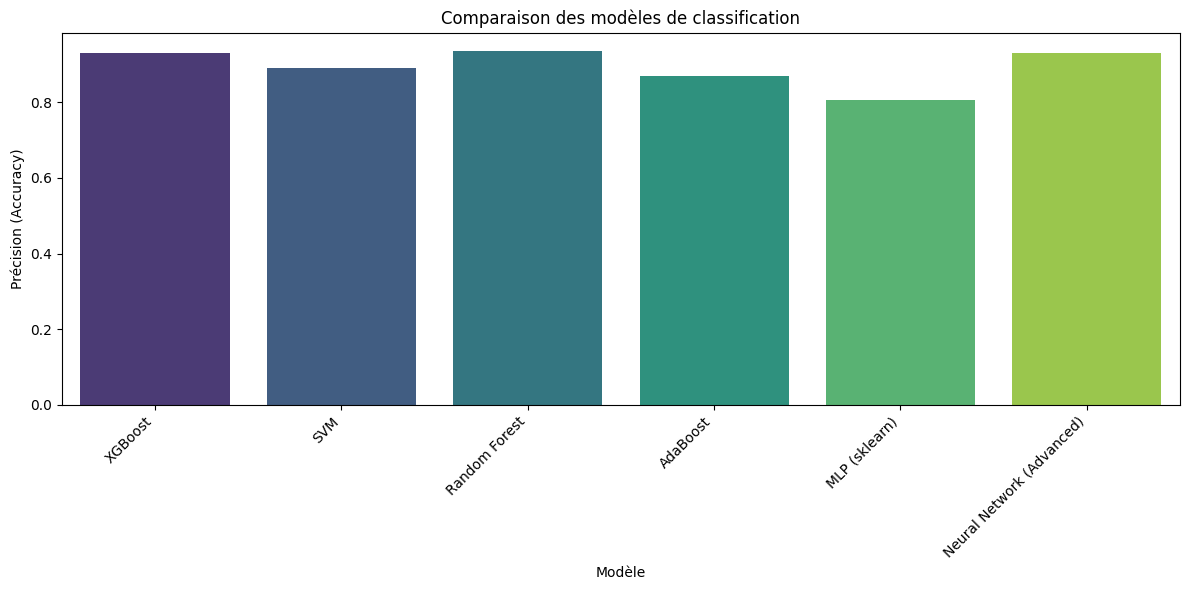

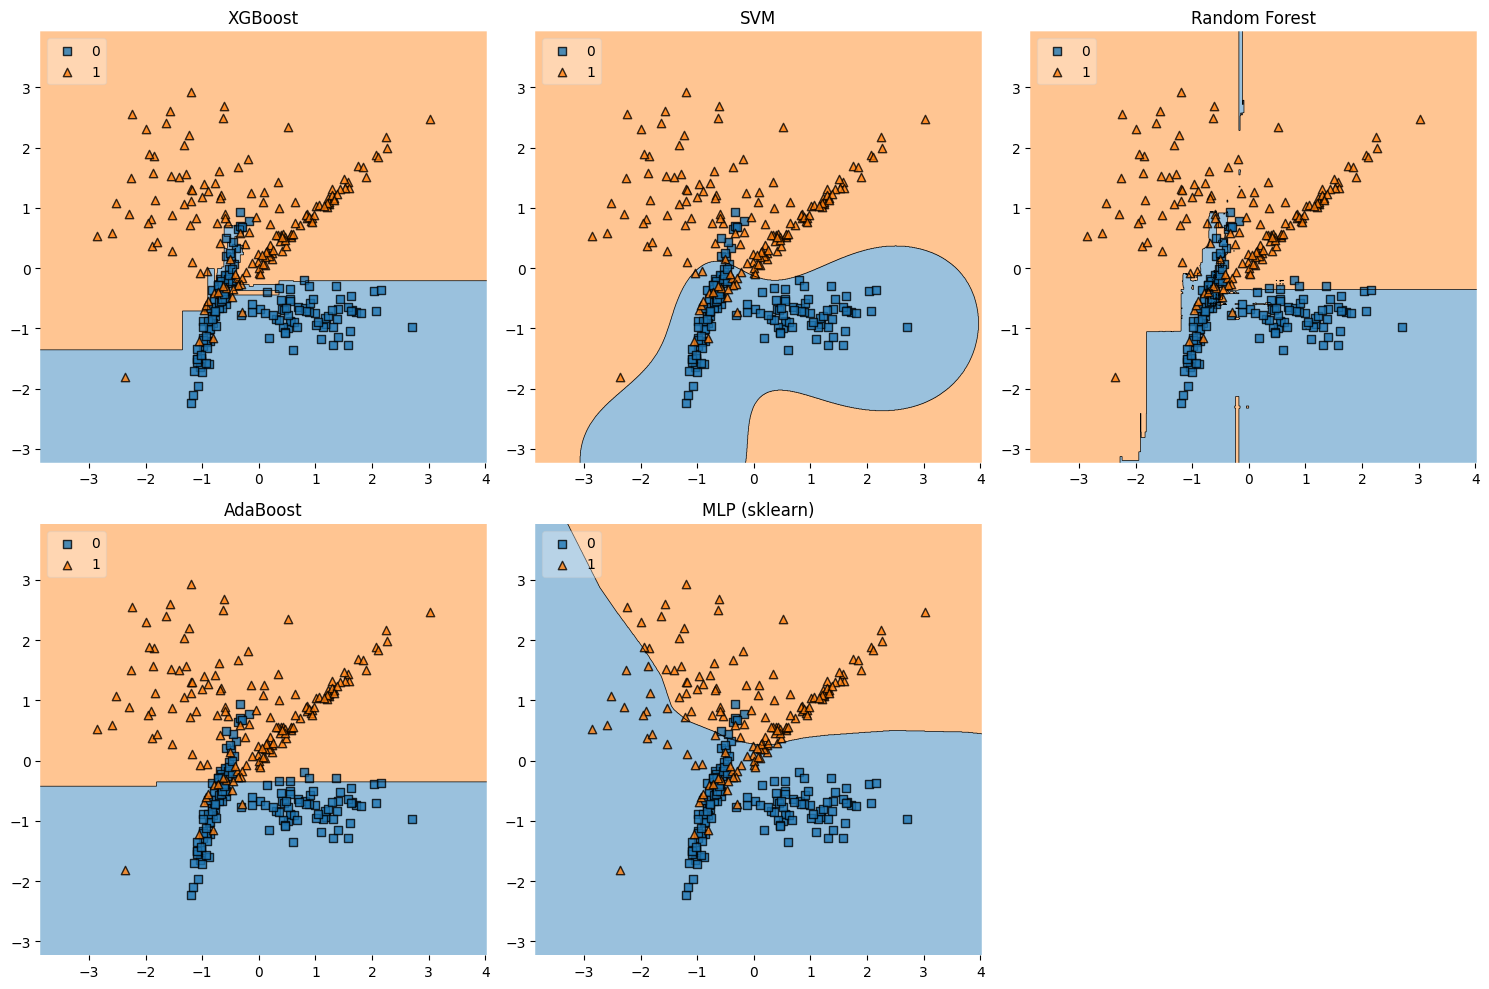


Rapports de classification détaillés:

XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       149
           1       0.95      0.91      0.93       151

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


SVM:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       149
           1       0.91      0.87      0.89       151

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300


Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       149
           1       0.95      0.93      0.94       151

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
wei

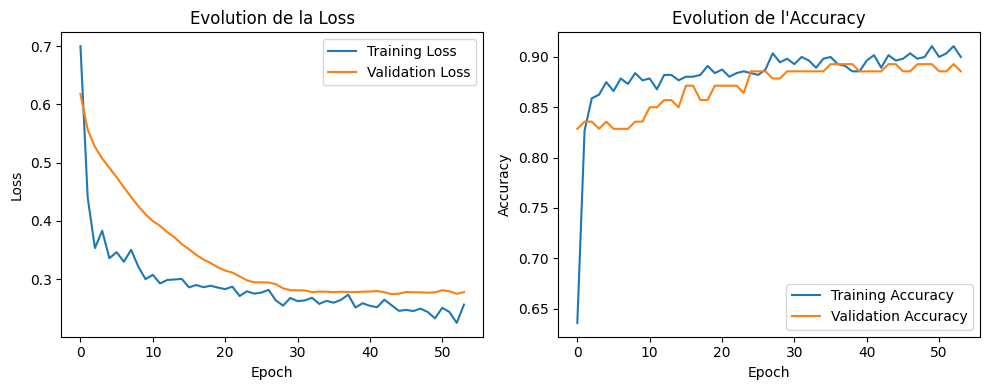

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

# Configuration des seeds pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

# Création d'un jeu de données plus complexe avec 2 features
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,  # Création de clusters plus complexes
    random_state=42
)

# Split des données avec stratification pour maintenir la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = []
models = {}

def evaluate_model(name, model, X_train_data, X_test_data, needs_scaling=True):
    """
    Utility function to evaluate a model with timing and cross-validation.
    """
    start_time = time.time()

    # Use standardized data if required
    X_train_eval = X_train_scaled if needs_scaling else X_train_data
    X_test_eval = X_test_scaled if needs_scaling else X_test_data

    if name == 'XGBoost':
        # Convert data to DMatrix, the optimized data structure for XGBoost
        dtrain = xgb.DMatrix(X_train_eval, label=y_train)
        dtest = xgb.DMatrix(X_test_eval, label=y_test)

        # Define XGBoost parameters
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 3
        }

        # Perform cross-validation using XGBoost's native method
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=100,
            nfold=5,
            metrics={'logloss'},
            seed=42,
            #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
        )

        # Calculate mean and standard deviation of log loss
        cv_mean = cv_results['test-logloss-mean'].iloc[-1]
        cv_std = cv_results['test-logloss-std'].iloc[-1]

        # Train the model
        model.fit(X_train_eval, y_train)

        # Predict and calculate accuracy on the test set
        y_pred = model.predict(X_test_eval)
        accuracy = accuracy_score(y_test, y_pred)

    else:
        # Train the model
        model.fit(X_train_eval, y_train)

        # Perform cross-validation using scikit-learn
        cv_scores = cross_val_score(model, X_train_eval, y_train, cv=5)

        # Calculate accuracy on the test set
        accuracy = model.score(X_test_eval, y_test)

        # Calculate mean and standard deviation of cross-validation scores
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

    # Calculate training time
    training_time = time.time() - start_time

    return accuracy, training_time, cv_mean, cv_std



# XGBoost (Scikit-learn API)
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
xgb_results = evaluate_model('XGBoost', xgb_model, X_train, X_test, needs_scaling=True)
results.append(['XGBoost', *xgb_results[:2], xgb_results[2]])
models['XGBoost'] = xgb_model

# SVM avec noyau RBF
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_results = evaluate_model('SVM', svm_model, X_train, X_test, needs_scaling=True)
results.append(['SVM', *svm_results[:2], svm_results[2]])
models['SVM'] = svm_model

# Random Forest avec hyperparamètres optimisés
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_results = evaluate_model('Random Forest', rf_model, X_train, X_test, needs_scaling=False)
results.append(['Random Forest', *rf_results[:2], rf_results[2]])
models['Random Forest'] = rf_model

# AdaBoost optimisé
adaboost_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada_results = evaluate_model('AdaBoost', adaboost_model, X_train, X_test, needs_scaling=False)
results.append(['AdaBoost', *ada_results[:2], ada_results[2]])
models['AdaBoost'] = adaboost_model

# MLP Scikit-learn avec architecture adaptée
mlp_model = MLPClassifier(
    hidden_layer_sizes=(32, 16),  # Architecture plus adaptée à 2 features
    max_iter=1000,
    early_stopping=True,
    random_state=42
)
mlp_results = evaluate_model('MLP (sklearn)', mlp_model, X_train, X_test, needs_scaling=True)
results.append(['MLP (sklearn)', *mlp_results[:2], mlp_results[2]])
models['MLP (sklearn)'] = mlp_model

# Création d'un modèle CNN 2D plus approprié
def create_advanced_nn_model():
    """
    Création d'un modèle de réseau de neurones avec une architecture plus sophistiquée
    """
    model = keras.Sequential([
        # Couche d'entrée
        layers.Dense(64, activation='relu', input_shape=(2,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Couche cachée
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Couche de sortie
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Entraînement du modèle neural avancé
start_time = time.time()
nn_model = create_advanced_nn_model()

# Callbacks pour l'entraînement
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entraînement avec validation
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

nn_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
nn_time = time.time() - start_time
results.append(['Neural Network (Advanced)', nn_accuracy, nn_time, np.nan])

# Création du DataFrame des résultats
results_df = pd.DataFrame(
    results,
    columns=['Model', 'Accuracy', 'Training Time (s)', 'CV Score']
)
print("\nRésultats de la comparaison des modèles:")
print(results_df.to_string(index=False))

# Visualisation des résultats
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.xlabel("Modèle")
plt.ylabel("Précision (Accuracy)")
plt.title("Comparaison des modèles de classification")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot des régions de décision
fig = plt.figure(figsize=(15, 10))
gs = plt.GridSpec(2, 3, figure=fig)

for i, (model_name, model) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    plot_decision_regions(X=X_test_scaled, y=y_test, clf=model, legend=2)
    plt.title(model_name)

plt.tight_layout()
plt.show()

# Affichage des rapports de classification détaillés
print("\nRapports de classification détaillés:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    y_pred = model.predict(X_test_scaled if model_name != 'Random Forest' else X_test)
    print(classification_report(y_test, y_pred))

# Visualisation de l'historique d'entraînement du réseau de neurones
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolution de la Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolution de l\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

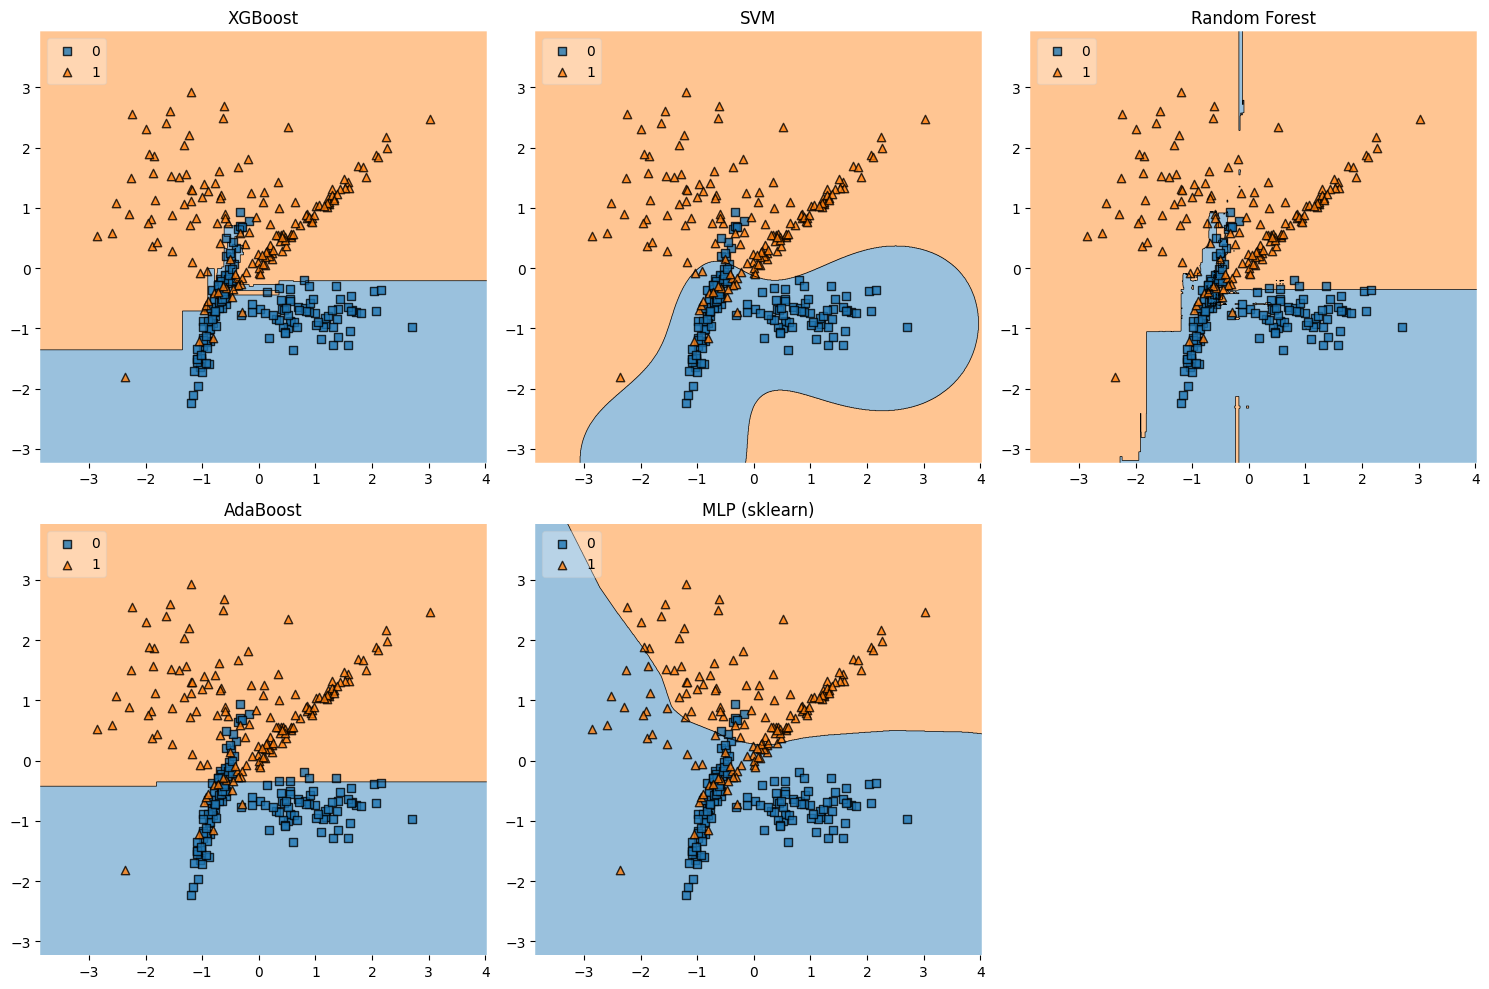

####2. Les 5 graphes obtenus montrent les "decisions boundaries". Classe les 5 modèles en 3 groupes selon la forme de "decision boundary". Ensuite justifie ces formes en quelques mots. Un snippet ci-dessous te permettra de tracer un tableau en python.

In [9]:

import pandas as pd

# Création du DataFrame avec les données spécifiées
data = {
    'model': ['a, b et c', 'd', 'e'],
    'decision boundary': ['Ligne droite', 'cercle', 'carré']
}

df = pd.DataFrame(data)

# Affichage du DataFrame
df

,model,decision boundary
0,"a, b et c",Ligne droite
1,d,cercle
2,e,carré





SVM (RBF) : Lisse


Les frontières de décision des SVM avec noyau RBF sont lisses, car elles sont continuellement différentiables. Cela signifie qu'il n'y a pas de discontinuités dans la séparation des classes, contrairement à des modèles comme les arbres de décision. La transformation via le noyau RBF génère une frontière fluide qui s'ajuste aux données de manière homogène.



Réseau de neurones (NN) : Non linéaire


Les réseaux de neurones ont des frontières de décision non linéaires, car les fonctions d'activation (comme ReLU ou sigmoïde) introduisent des non-linéarités dans le modèle. Cela permet aux réseaux de neurones de capturer des relations complexes et de séparer les classes de manière non linéaire. Cependant, ces frontières peuvent être assez flexibles et ajustées pour s'adapter aux données, ce qui leur donne une forme complexe mais continue.



XGBoost : Rectiligne


XGBoost, en tant que modèle basé sur des arbres de décision, génère des frontières de décision rectilignes. Chaque arbre sépare les classes avec des segments de droites parallèles aux axes des caractéristiques. Toutefois, le boosting permet d'ajouter plusieurs arbres, ce qui permet à l'ensemble de donner une forme de frontière plus complexe, mais toujours composée de segments droits. La frontière est donc rectiligne, mais l'ensemble des arbres peut créer une frontière composite plus complexe et plus flexible.



En résumé, SVM (RBF) produit une frontière lisse et continue, les réseaux de neurones produisent des frontières non linéaires, tandis que XGBoost génère des frontières rectilignes en raison de sa structure basée sur des arbres de décision.

####**3-** Remet à leurs places les différents commentaires:

Questions Théoriques
Expliquez le processus de standardisation des données. Pourquoi est-il important dans ce contexte ?
Pourquoi utilisons-nous la stratification lors de la division des données en ensembles d'apprentissage et de test ?
Quelles sont les différences entre les algorithmes SVM, Random Forest, AdaBoost, MLP et XGBoost ?
Questions Pratiques
Ajoutez un modèle supplémentaire (comme un K-Nearest Neighbors) à ce code et comparez ses performances avec celles des autres modèles.
Modifiez l'architecture du modèle de réseau de neurones avancé pour améliorer ses performances. Décrivez les changements effectués et leur impact sur les résultats.
Expérimentez avec différents jeux de paramètres pour le modèle XGBoost. Comparez les performances obtenues et expliquez pourquoi certains paramètres fonctionnent mieux que d'autres.
Questions d'Analyse
Expliquez les graphiques de l'historique d'entraînement du réseau de neurones. Que pouvez-vous en déduire concernant le surapprentissage ou le sous-apprentissage ?
Interprétez les rapports de classification pour chaque modèle. Quel modèle semble le plus performant pour ce jeu de données, et pourquoi ?
Analysez les régions de décision tracées pour chaque modèle. Quels modèles semblent avoir les frontières de décision les plus complexes, et pourquoi cela pourrait-il être bénéfique ou problématique ?